In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from utils import read_wiki_data, clean_wiki_data, read_gab_data, read_jigsaw_data, read_twitter_data, save_embeddings, load_embeddings, is_available
from embeddings import get_bert_embeddings
from model import get_dense_model
from evaluation import eval_report, mcnemar_test
from plot import plot_perf
from configs import config as cf

# GAB

In [2]:
data = read_gab_data()

if is_available(cf.gab_embeddings_path):
    sentence_embeddings = load_embeddings(dataset='gab')
else:
    sentence_embeddings = get_bert_embeddings(data['comment'])
    save_embeddings(sentence_embeddings, dataset='gab')

_, val_test_df = train_test_split(data, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
_, test_df = train_test_split(val_test_df, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)
test_labels = np.array(test_df['target']).reshape(-1, 1).astype(float)
test_groups = np.array(test_df[cf.identity_keys_gab]).astype(int)
_, val_test = train_test_split(sentence_embeddings, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
_, test = train_test_split(val_test, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)

Data shape=(27665, 10)
	Embeddings (shape=(27665, 512)) loaded successfully.


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Baseline (unconstrained)

Evaluation on test data:
	AUC = 0.8723
	Accuracy = 87.69 %
	Matthews correlation coefficient = 0.4093
		Group-specific MCCs = [0.2396 0.1978 0.4728]
	f1 score = 0.4464
	Precision = 0.3411
		Group-specific precisions = [0.6058 0.6286 0.675 ]
	Recall (sensitivity) = 0.6458
		Group-specific recalls = [0.7411 0.7483 0.6835]
	False negative (miss) rate = 35.4232 %
		Group-specific false negative rates = [25.89 25.17 31.65] %
	False positive (false alarm) rate = 10.3889 %
		Group-specific false positive rates = [50.94 56.03 20.97] %
	False negative equality difference (per group) = 0.0785 | total FNED = 0.2356
	False positive equality difference (per group) = 0.3226 | total FPED = 0.9678
	Total equality difference (bias) = 1.2034


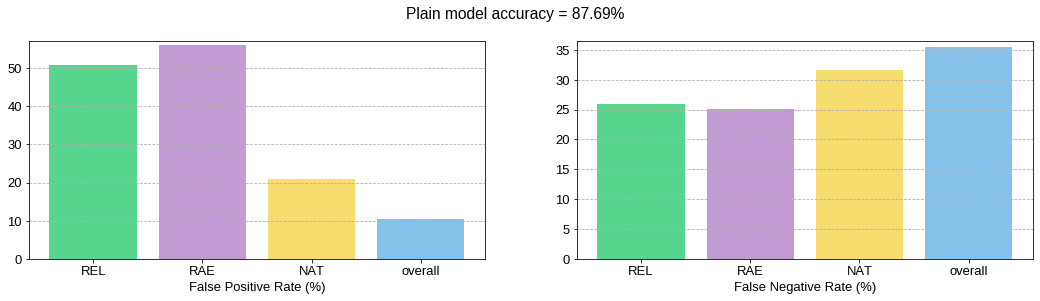

In [3]:
plain_model = get_dense_model()
plain_model.load_weights('{}/{}.h5'.format(cf.MODELS_DIR, cf.gab_plain_model_name))
test_preds_plain = plain_model.predict_classes(test, batch_size=cf.hyperparams['batch_size'])
test_probs_plain = plain_model.predict(test, batch_size=cf.hyperparams['batch_size'])

eval_report(test_labels, test_preds_plain, test_probs_plain, test_groups)
plot_perf(test_labels, test_preds_plain, test_groups, cf.identity_keys_gab, 'Plain model')

### Fairness Constrained

Evaluation on test data:
	AUC = 0.8319
	Accuracy = 91.66 %
	Matthews correlation coefficient = 0.4242
		Group-specific MCCs = [0.279  0.2254 0.4116]
	f1 score = 0.4693
	Precision = 0.4595
		Group-specific precisions = [0.6667 0.6774 0.7143]
	Recall (sensitivity) = 0.4796
		Group-specific recalls = [0.5893 0.5714 0.5063]
	False negative (miss) rate = 52.0376 %
		Group-specific false negative rates = [41.07 42.86 49.37] %
	False positive (false alarm) rate = 4.6985 %
		Group-specific false positive rates = [31.13 34.48 12.9 ] %
	False negative equality difference (per group) = 0.0761 | total FNED = 0.2282
	False positive equality difference (per group) = 0.2147 | total FPED = 0.6442
	Total equality difference (bias) = 0.8724


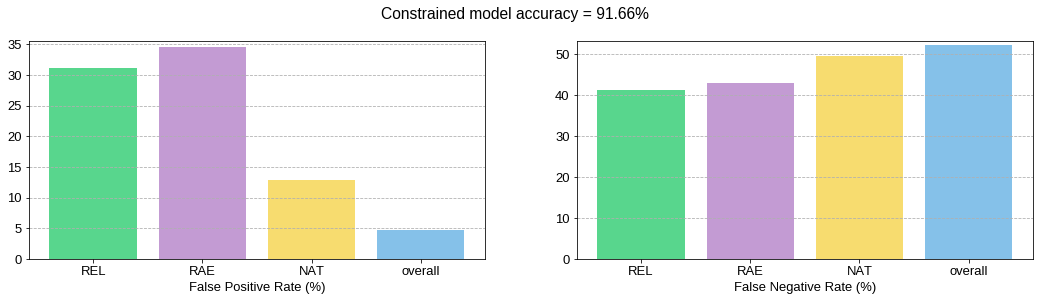

In [4]:
constrained_model = get_dense_model()
constrained_model.load_weights('{}/{}.h5'.format(cf.MODELS_DIR, cf.gab_constrained_model_name))

test_preds_const = constrained_model.predict_classes(test, batch_size=cf.hyperparams['batch_size'])
test_probs_const = constrained_model.predict(test, batch_size=cf.hyperparams['batch_size'])

eval_report(test_labels, test_preds_const, test_probs_const, test_groups)
plot_perf(test_labels, test_preds_const, test_groups, cf.identity_keys_gab, 'Constrained model')

In [5]:
mcnemar_test(labels=test_labels.ravel(), model1_preds=test_preds_plain.ravel(), model1_name='Baseline model', 
                                         model2_preds=test_preds_const.ravel(), model2_name='Constrained model')

                           Baseline model correct  Baseline model wrong
Constrained model correct                    3582                   222
Constrained model wrong                        57                   289

'mlxtend' library implementation
	chi-squared = 57
	p-value = 3.639461124585745e-24

'statsmodels' library implementation
pvalue      3.639461124585745e-24
statistic   57.0


# Twitter

In [6]:
data = read_twitter_data()

if is_available(cf.twitter_embeddings_path):
    sentence_embeddings = load_embeddings(dataset='twitter')
else:
    sentence_embeddings = get_bert_embeddings(data['comment'])
    save_embeddings(sentence_embeddings, dataset='twitter')

_, val_test_df = train_test_split(data, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
_, test_df = train_test_split(val_test_df, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)
test_labels = np.array(test_df['target']).reshape(-1, 1).astype(float)
test_groups = np.array(test_df[cf.identity_keys_twitter]).astype(int)
_, val_test = train_test_split(sentence_embeddings, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
_, test = train_test_split(val_test, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)

/home/tds/Projects/Ouz/fair_cb_public_repo/fair_cyberbullying_detection/source/utils.py:234: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  full_data = pd.concat(full_data)


Data shape=(107441, 21)
	Embeddings (shape=(107441, 512)) loaded successfully.


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Baseline (unconstrained)

Evaluation on test data:
	AUC = 0.9224
	Accuracy = 86.47 %
	Matthews correlation coefficient = 0.6524
		Group-specific MCCs = [0.7108 0.3152 0.263  0.23   0.3287]
	f1 score = 0.7408
	Precision = 0.6950
		Group-specific precisions = [0.7441 0.3769 0.3978 0.3617 0.5434]
	Recall (sensitivity) = 0.7930
		Group-specific recalls = [0.8397 0.6084 0.25   0.3542 0.7132]
	False negative (miss) rate = 20.6976 %
		Group-specific false negative rates = [16.03 39.16 75.   64.58 28.68] %
	False positive (false alarm) rate = 11.2150 %
		Group-specific false positive rates = [10.19 23.82  3.77 12.61 37.56] %
	False negative equality difference (per group) = 0.2586 | total FNED = 1.2929
	False positive equality difference (per group) = 0.0976 | total FPED = 0.4881
	Total equality difference (bias) = 1.7810


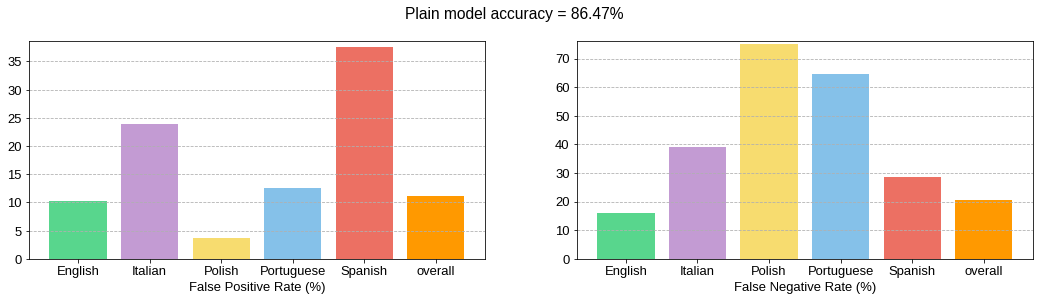

In [7]:
plain_model = get_dense_model()
plain_model.load_weights('{}/{}.h5'.format(cf.MODELS_DIR, cf.twitter_plain_model_name))
test_preds_plain = plain_model.predict_classes(test, batch_size=cf.hyperparams['batch_size'])
test_probs_plain = plain_model.predict(test, batch_size=cf.hyperparams['batch_size'])

eval_report(test_labels, test_preds_plain, test_probs_plain, test_groups)
plot_perf(test_labels, test_preds_plain, test_groups, cf.identity_keys_twitter, 'Plain model')

### Fairness Constrained

Evaluation on test data:
	AUC = 0.9014
	Accuracy = 87.83 %
	Matthews correlation coefficient = 0.6594
		Group-specific MCCs = [0.7098 0.3324 0.3003 0.3348 0.3354]
	f1 score = 0.7364
	Precision = 0.7801
		Group-specific precisions = [0.816  0.4797 0.5439 0.5333 0.6064]
	Recall (sensitivity) = 0.6973
		Group-specific recalls = [0.7498 0.4277 0.2095 0.3333 0.5551]
	False negative (miss) rate = 30.2699 %
		Group-specific false negative rates = [25.02 57.23 79.05 66.67 44.49] %
	False positive (false alarm) rate = 6.3336 %
		Group-specific false positive rates = [ 5.97 10.98  1.75  5.88 22.58] %
	False negative equality difference (per group) = 0.2632 | total FNED = 1.3161
	False positive equality difference (per group) = 0.0526 | total FPED = 0.2630
	Total equality difference (bias) = 1.5791


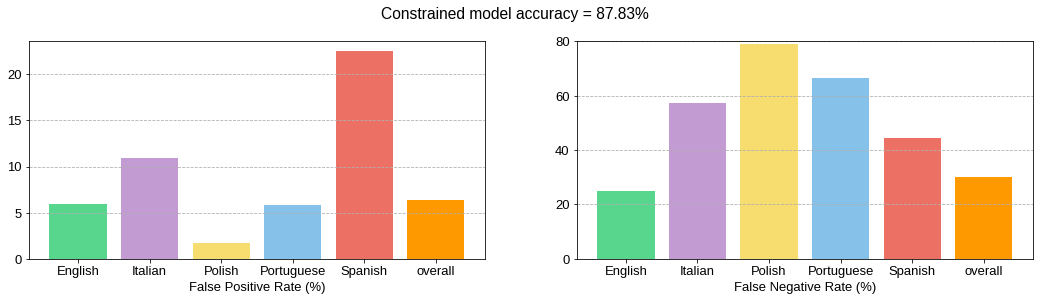

In [8]:
constrained_model = get_dense_model()
constrained_model.load_weights('{}/{}.h5'.format(cf.MODELS_DIR, cf.twitter_constrained_model_name))

test_preds_const = constrained_model.predict_classes(test, batch_size=cf.hyperparams['batch_size'])
test_probs_const = constrained_model.predict(test, batch_size=cf.hyperparams['batch_size'])

eval_report(test_labels, test_preds_const, test_probs_const, test_groups)
plot_perf(test_labels, test_preds_const, test_groups, cf.identity_keys_twitter, 'Constrained model')

In [9]:
mcnemar_test(labels=test_labels.ravel(), model1_preds=test_preds_plain.ravel(), model1_name='Baseline model', 
                                         model2_preds=test_preds_const.ravel(), model2_name='Constrained model')

                           Baseline model correct  Baseline model wrong
Constrained model correct                   13398                   758
Constrained model wrong                       539                  1422

'mlxtend' library implementation
	chi-squared = 539
	p-value = 1.301384839995257e-09

'statsmodels' library implementation
pvalue      1.301384839995257e-09
statistic   539.0


# Jigsaw

In [10]:
data = read_jigsaw_data()

if is_available(cf.jigsaw_embeddings_path):
    sentence_embeddings = load_embeddings(dataset='jigsaw')
else:
    sentence_embeddings = get_bert_embeddings(data['comment'])
    save_embeddings(sentence_embeddings, dataset='jigsaw')
    
_, val_test_df = train_test_split(data, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
_, test_df = train_test_split(val_test_df, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)
test_labels = np.array(test_df['target']).reshape(-1, 1).astype(float)
test_groups = np.array(test_df[cf.identity_keys_jigsaw]).astype(int)
_, val_test = train_test_split(sentence_embeddings, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
_, test = train_test_split(val_test, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)

Data shape=(403957, 4)
	Embeddings (shape=(403957, 512)) loaded successfully.


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Baseline (unconstrained)

Evaluation on test data:
	AUC = 0.8839
	Accuracy = 83.66 %
	Matthews correlation coefficient = 0.4578
		Group-specific MCCs = [0.4273 0.401 ]
	f1 score = 0.5125
	Precision = 0.3904
		Group-specific precisions = [0.3831 0.3544]
	Recall (sensitivity) = 0.7455
		Group-specific recalls = [0.7627 0.7317]
	False negative (miss) rate = 25.4512 %
		Group-specific false negative rates = [23.73 26.83] %
	False positive (false alarm) rate = 15.1589 %
		Group-specific false positive rates = [21.43 20.48] %
	False negative equality difference (per group) = 0.0155 | total FNED = 0.0310
	False positive equality difference (per group) = 0.0580 | total FPED = 0.1159
	Total equality difference (bias) = 0.1469


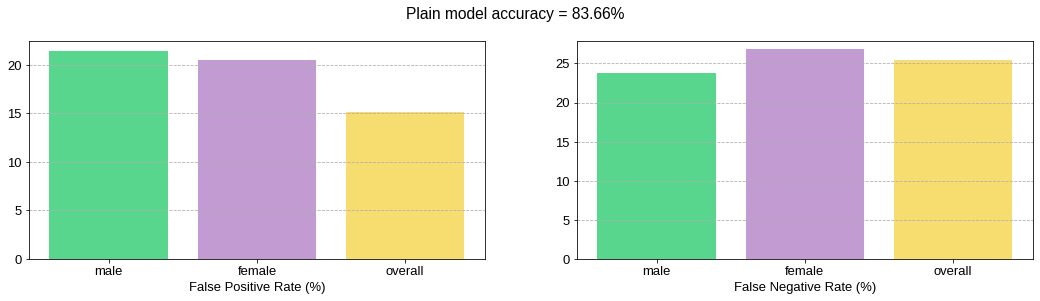

In [11]:
plain_model = get_dense_model()
plain_model.load_weights('{}/{}.h5'.format(cf.MODELS_DIR, cf.jigsaw_plain_model_name))
test_preds_plain = plain_model.predict_classes(test, batch_size=cf.hyperparams['batch_size'])
test_probs_plain = plain_model.predict(test, batch_size=cf.hyperparams['batch_size'])

eval_report(test_labels, test_preds_plain, test_probs_plain, test_groups)
plot_perf(test_labels, test_preds_plain, test_groups, cf.identity_keys_jigsaw, 'Plain model')

### Fairness Constrained

Evaluation on test data:
	AUC = 0.8642
	Accuracy = 90.19 %
	Matthews correlation coefficient = 0.4847
		Group-specific MCCs = [0.4531 0.4704]
	f1 score = 0.5367
	Precision = 0.5889
		Group-specific precisions = [0.5671 0.5806]
	Recall (sensitivity) = 0.4930
		Group-specific recalls = [0.4929 0.4934]
	False negative (miss) rate = 50.7018 %
		Group-specific false negative rates = [50.71 50.66] %
	False positive (false alarm) rate = 4.4822 %
		Group-specific false positive rates = [6.57 5.48] %
	False negative equality difference (per group) = 0.0003 | total FNED = 0.0005
	False positive equality difference (per group) = 0.0154 | total FPED = 0.0308
	Total equality difference (bias) = 0.0313


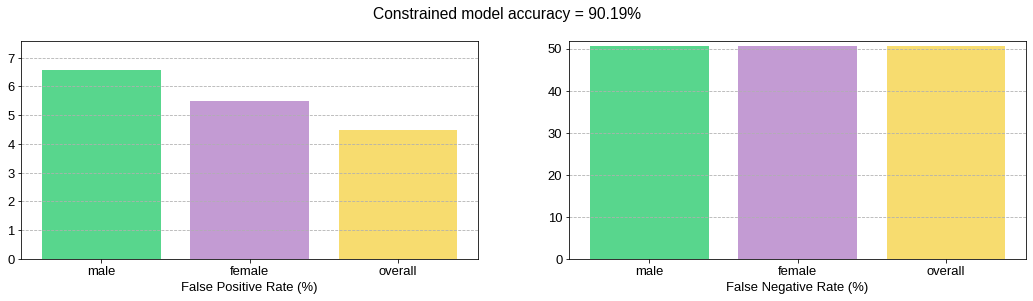

In [12]:
constrained_model = get_dense_model()
constrained_model.load_weights('{}/{}.h5'.format(cf.MODELS_DIR, cf.jigsaw_constrained_model_name))

test_preds_const = constrained_model.predict_classes(test, batch_size=cf.hyperparams['batch_size'])
test_probs_const = constrained_model.predict(test, batch_size=cf.hyperparams['batch_size'])

eval_report(test_labels, test_preds_const, test_probs_const, test_groups)
plot_perf(test_labels, test_preds_const, test_groups, cf.identity_keys_jigsaw, 'Constrained model')

In [13]:
mcnemar_test(labels=test_labels.ravel(), model1_preds=test_preds_plain.ravel(), model1_name='Baseline model', 
                                         model2_preds=test_preds_const.ravel(), model2_name='Constrained model')

                           Baseline model correct  Baseline model wrong
Constrained model correct                   48802                  5849
Constrained model wrong                      1888                  4055

'mlxtend' library implementation
	chi-squared = 1888
	p-value = 0.0

'statsmodels' library implementation
pvalue      0.0
statistic   1888.0


# Wiki

In [14]:
data_all = [clean_wiki_data(read_wiki_data(m), m) for m in cf.wiki_modes]

# extract observations that contain all annotations
valid_observations = list(set.intersection(set(data_all[0].rev_id), set(data_all[1].rev_id), set(data_all[2].rev_id)))
print('{} observations have all of the annotations.'.format(len(valid_observations)))

for d in data_all:
    d.set_index('rev_id', inplace=True)
    
data = pd.merge(data_all[0].loc[valid_observations,:], data_all[1].loc[valid_observations,:]['is_aggression'], on='rev_id').merge(data_all[2].loc[valid_observations,:]['is_attack'], on='rev_id')
data['recent'] = data['year'] >= cf.wiki_year_thres
data['older'] = ~data['recent']
data['target'] = data['toxicity'] >= cf.target_thres

if is_available(cf.wiki_embeddings_path):
    sentence_embeddings = load_embeddings(dataset='wiki')
else:
    sentence_embeddings = get_bert_embeddings(data['comment'])
    save_embeddings(sentence_embeddings, dataset='wiki')
    
    
_, val_test_df = train_test_split(data, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
_, test_df = train_test_split(val_test_df, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)
test_labels = np.array(test_df['target']).reshape(-1, 1).astype(float)
test_groups = np.array(test_df[cf.wiki_identities]).astype(int)
_, val_test = train_test_split(sentence_embeddings, train_size=cf.train_size, random_state=cf.random_state, shuffle=True)
_, test = train_test_split(val_test, train_size=cf.val_test_ratio, random_state=cf.random_state, shuffle=True)

Data shape _toxicity_=(159686, 7), annotations shape=(1598289, 4)
Data shape _aggression_=(115864, 7), annotations shape=(1365217, 4)
Data shape _attack_=(115864, 7), annotations shape=(1365217, 8)
77972 observations have all of the annotations.
	Embeddings (shape=(77972, 512)) loaded successfully.


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Baseline (unconstrained)

Evaluation on test data:
	AUC = 0.9494
	Accuracy = 89.81 %
	Matthews correlation coefficient = 0.7092
		Group-specific MCCs = [0.7028 0.7096]
	f1 score = 0.7723
	Precision = 0.7272
		Group-specific precisions = [0.7229 0.7275]
	Recall (sensitivity) = 0.8232
		Group-specific recalls = [0.8108 0.824 ]
	False negative (miss) rate = 17.6782 %
		Group-specific false negative rates = [18.92 17.6 ] %
	False positive (false alarm) rate = 8.2026 %
		Group-specific false positive rates = [7.8  8.23] %
	False negative equality difference (per group) = 0.0066 | total FNED = 0.0132
	False positive equality difference (per group) = 0.0022 | total FPED = 0.0043
	Total equality difference (bias) = 0.0175


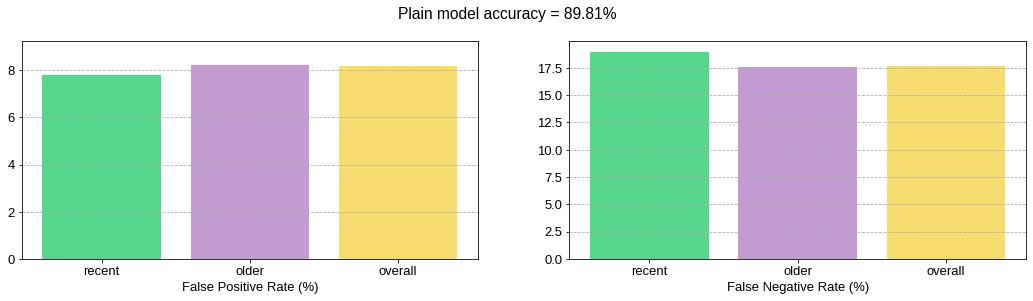

In [15]:
plain_model = get_dense_model()
plain_model.load_weights('{}/{}.h5'.format(cf.MODELS_DIR, cf.wiki_plain_model_name))
test_preds_plain = plain_model.predict_classes(test, batch_size=cf.hyperparams['batch_size'])
test_probs_plain = plain_model.predict(test, batch_size=cf.hyperparams['batch_size'])

eval_report(test_labels, test_preds_plain, test_probs_plain, test_groups)
plot_perf(test_labels, test_preds_plain, test_groups, cf.wiki_identities, 'Plain model')

### Fairness Constrained

Evaluation on test data:
	AUC = 0.9587
	Accuracy = 93.82 %
	Matthews correlation coefficient = 0.8071
		Group-specific MCCs = [0.8074 0.8071]
	f1 score = 0.8418
	Precision = 0.9096
		Group-specific precisions = [0.9062 0.9099]
	Recall (sensitivity) = 0.7833
		Group-specific recalls = [0.7838 0.7833]
	False negative (miss) rate = 21.6701 %
		Group-specific false negative rates = [21.62 21.67] %
	False positive (false alarm) rate = 2.0669 %
		Group-specific false positive rates = [2.03 2.07] %
	False negative equality difference (per group) = 0.0003 | total FNED = 0.0005
	False positive equality difference (per group) = 0.0002 | total FPED = 0.0004
	Total equality difference (bias) = 0.0009


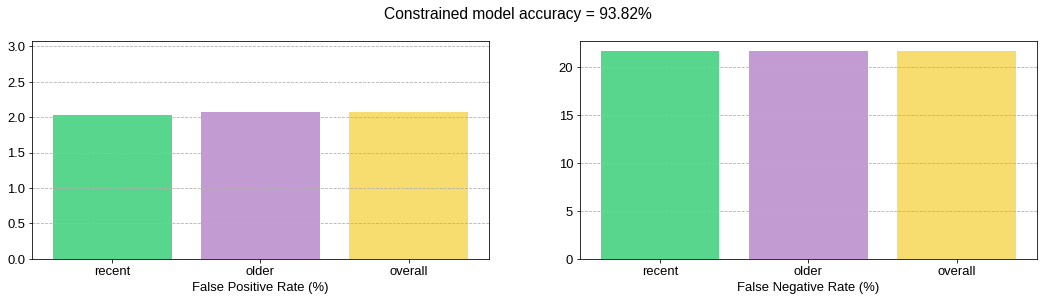

In [16]:
constrained_model = get_dense_model()
constrained_model.load_weights('{}/{}.h5'.format(cf.MODELS_DIR, cf.wiki_constrained_model_name))

test_preds_const = constrained_model.predict_classes(test, batch_size=cf.hyperparams['batch_size'])
test_probs_const = constrained_model.predict(test, batch_size=cf.hyperparams['batch_size'])

eval_report(test_labels, test_preds_const, test_probs_const, test_groups)
plot_perf(test_labels, test_preds_const, test_groups, cf.wiki_identities, 'Constrained model')

In [17]:
mcnemar_test(labels=test_labels.ravel(), model1_preds=test_preds_plain.ravel(), model1_name='Baseline model', 
                                         model2_preds=test_preds_const.ravel(), model2_name='Constrained model')

                           Baseline model correct  Baseline model wrong
Constrained model correct                   10205                   768
Constrained model wrong                       299                   424

'mlxtend' library implementation
	chi-squared = 299
	p-value = 4.146890649078966e-48

'statsmodels' library implementation
pvalue      4.146890649078966e-48
statistic   299.0
